# Forward dynamics of infection on Zachary’s karate club data
Comparison with Fig. 2 in *Ortega et. al*, [Dynamics of epidemics from cavity master equations: Susceptible-infectious-susceptible models](https://doi.org/10.1103/PhysRevE.105.024308)

In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/MatrixProductBP`


In [2]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, DelimitedFiles, Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [3]:
# read matrix of contacts, found at http://konect.cc/networks/ucidata-zachary/
A = readdlm("karate.txt", Bool)
g = IndexedGraph(A);

In [63]:
N = nv(g)  # number of individuals
T = 50     # final time
ΔT = 0.75   # discretization
λ = 0.1    # prob. of transmission
ρ = 0.05   # prob. of recovery

# prob. of being infected at time zero
p⁰ = map(1:N) do i
   if i == 1
        [0.0, 1.0]   # node 1 is infected at time zero
    else
        [1.0, 0.0]   # all other nodes start as susceptible
    end
end

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*ΔT, ρ*ΔT, floor(Int, T/ΔT); p⁰)

# set up MPBP computation
bp = mpbp(sis);

In [64]:
svd_trunc = TruncBond(6)   # maximum matrix size for SVD-based truncation
maxiter = 10
tol = 1e-3

# run MPBP
iters, cb = iterate!(bp; svd_trunc, maxiter, tol);

Running MPBP: iter 2 	 Time: 0:02:01
  Δ:  5.73354624496401e-16

In [65]:
if iters < maxiter
    println("BP converged after $iters iterations")
else
    println("BP did not meet criteria for convergence after $maxiter iterations")
end

BP converged after 2 iterations


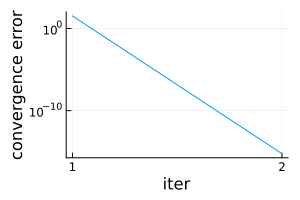

In [66]:
plot(cb.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="", xticks=1:iters)

In [67]:
# compute marginals
b_bp = beliefs(bp)
p29_bp = [bb[INFECTED] for bb in b_bp[29]];

In [68]:
# run soft margin montecarlo and compute marginals
nsamples_mc = 10^5
sms = sample(bp, nsamples_mc)
b_mc = marginals(sms)
p29_mc = [bb[INFECTED] for bb in b_mc[29]];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:03:00


In [69]:
pl = plot(xlabel="time", xticks=0:10:T, ylabel="\$P(x_{29}^t=I)\$", ylims=(-0.05,1), legend=:bottomright)
plot!(pl, 0:ΔT:T, p29_bp, m=:o, ms=2, label="MPBP")
plot!(pl, 0:ΔT:T, p29_mc, m=:x, ms=2, label="MC");

In [70]:
pl_err = plot(xlabel="time", xticks=0:10:T, ylims=(-0.01,0.3))
plot!(pl_err, 0:ΔT:T, abs.(p29_bp.-p29_mc), label="", ylabel="L₁-error");

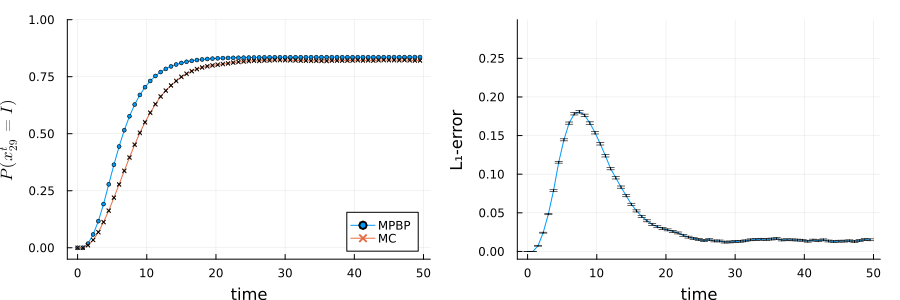

In [71]:
plot(pl, pl_err, size=(900,300), margin=3Plots.mm)

Compare with:

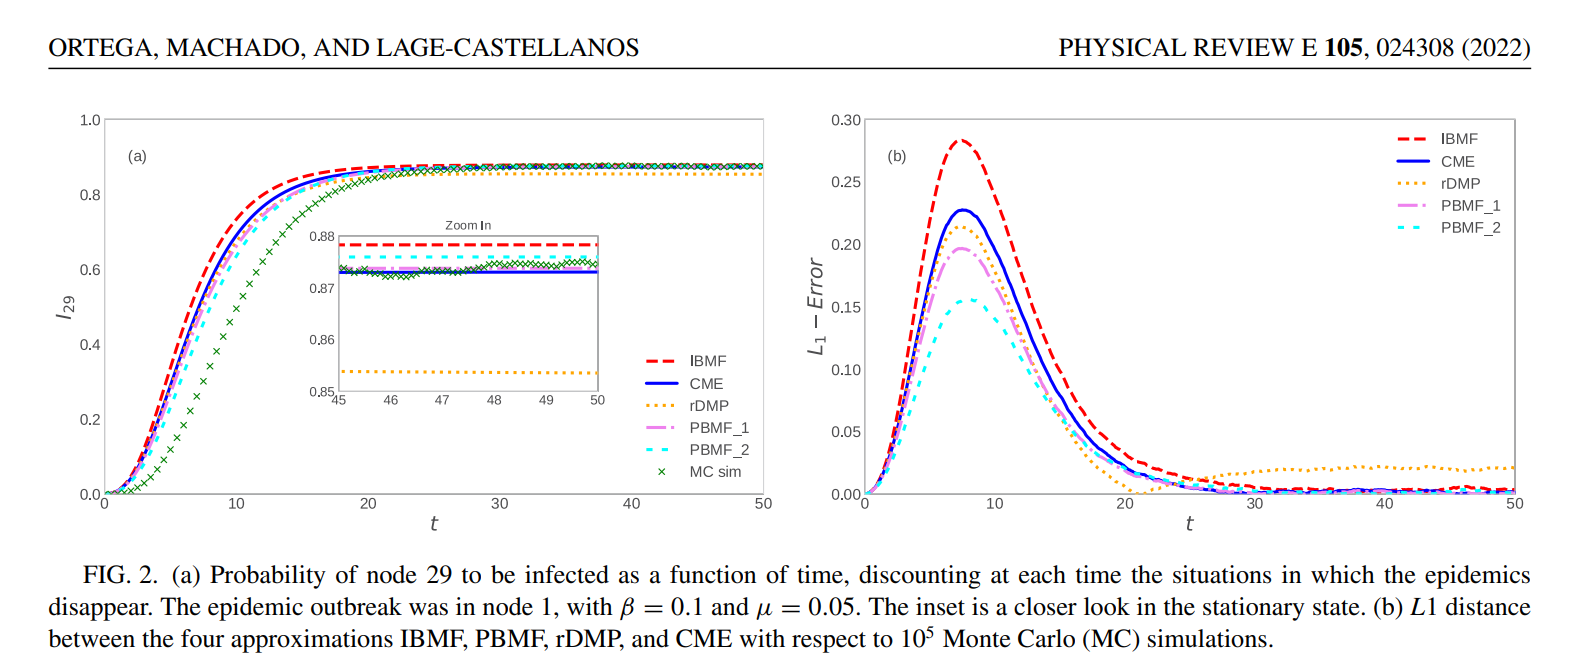